In [1]:
%cd ..

/home/dmoreno/pipeline_v4_final/pipeline/training/stamp_classifier/models/experimentation/stamp_full


In [2]:
import tensorflow as tf
from data_loader import get_tf_datasets
from model import StampModelFull
tf.__version__

2025-06-02 19:20:59.109283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748892059.129195 2510869 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748892059.135617 2510869 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-02 19:20:59.156449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.18.0'

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import det_curve, DetCurveDisplay
from itertools import product

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, datetime

In [5]:
normalized_ndarrays = pd.read_pickle('./data/normalized_ndarrays_hasavro.pkl')
normalized_ndarrays

{'x_train': array([[[[ 0.04497211,  0.02093354, -0.01123271,  0.        ,
            0.        ,  0.        ],
          [ 0.03947692,  0.01557314, -0.04732214,  0.        ,
            0.        ,  0.        ],
          [ 0.04563395,  0.02553637,  0.01309162,  0.        ,
            0.        ,  0.        ],
          ...,
          [ 0.05896267,  0.01957969,  0.12338348,  0.        ,
            0.        ,  0.        ],
          [ 0.03021978,  0.00724135, -0.11492626,  0.        ,
            0.        ,  0.        ],
          [ 0.03651536,  0.01967266, -0.07559172,  0.        ,
            0.        ,  0.        ]],
 
         [[ 0.03329531,  0.02688228, -0.10677241,  0.        ,
            0.        ,  0.        ],
          [ 0.03730946,  0.0235098 , -0.06859998,  0.        ,
            0.        ,  0.        ],
          [ 0.04752988,  0.02857298,  0.02302664,  0.        ,
            0.        ,  0.        ],
          ...,
          [ 0.04229983,  0.01349941,  0.0128994

In [6]:
oids_test = normalized_ndarrays['oid_test']
oids_test

array(['ZTF19aadmuyr', 'ZTF18aatljmd', 'ZTF19aaskwqn', ...,
       'ZTF19abegocq', 'ZTF17aabralf', 'ZTF18abmrdyx'], dtype=object)

In [7]:
LabelEncoder = normalized_ndarrays['label_encoder']
del normalized_ndarrays

In [8]:
LabelEncoder

LabelEncoder()

In [9]:
LabelEncoder.classes_

array(['agn', 'asteroid', 'bogus', 'satellite', 'sn', 'vs'], dtype=object)

In [10]:
N_CLASSES = 6
BATCH_SIZE = 64
LABELS = [
    'agn',
    'asteroid',
    'bogus',
    'satellite',
    'sn',
    'vs'
]

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = 'MIG-802fb5a9-d98a-5bce-ad53-9227189dc2cf'

In [ ]:
def evaluate_dataset(classifier, dataset):
    y_list = []
    predicted_probs_list = []
    images = []
    for X, pos, y in dataset:
        predicted_probs = tf.nn.softmax(classifier((X, pos)))
        y = y.numpy()
        y_list.append(y)
        predicted_probs_list.append(predicted_probs.numpy())
        images.append(X.numpy())
    predicted_probs = np.concatenate(predicted_probs_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    predictions = tf.argmax(predicted_probs, axis=1).numpy()
    return y, predicted_probs, predictions, images


In [15]:
list(range(1))

[0]

In [16]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

dataset_name = 'full'
BATCH_SIZE = 32  # Ajusta según tu configuración

all_conf_matrices = []
all_class_reports = []

for i in range(1):  # Para las 5 corridas
   with tf.device('/cpu:0'):
      training_dataset, testidation_dataset, test_dataset, dict_mapping_classes, features = get_tf_datasets(batch_size=BATCH_SIZE)
      
      # Cargar el modelo entrenado para la corrida i
      ## POSITION
      #stamp_classifier = tf.keras.models.load_model(f'results/2025-05-28_17-53-52/run_{i}/model.keras')

      ## Metadatos
      stamp_classifier = tf.keras.models.load_model(f'results/2025-05-30_14-45-35/run_{i}/model.keras')

      # Obtener predicciones
      y_test, test_predicted_probs, test_predictions, images_test = evaluate_dataset(stamp_classifier, test_dataset)

      y_test_labels = LabelEncoder.inverse_transform(y_test)
      test_predictions_labels = LabelEncoder.inverse_transform(test_predictions)

      # Calcular la matriz de confusión
      conf_matrix = confusion_matrix(y_test_labels, test_predictions_labels, labels=LabelEncoder.classes_, normalize='true')
      all_conf_matrices.append(conf_matrix)

      # Calcular el classification report
      report = classification_report(y_test_labels, test_predictions_labels, output_dict=True)
      all_class_reports.append(report)

I0000 00:00:1748892091.732819 2510869 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18211 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:82:00.0, compute capability: 8.0


x_train.shape final (29109, 63, 63, 6)
Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.
tf.Tensor(
[[-3.66392699e-01  1.07972473e-01 -4.13359010e-01  3.12597780e-01
   2.32853629e-01  3.34126485e-01 -4.39476296e-02 -1.10882577e+00
  -6.52485725e-01  1.00011519e+00 -3.17518907e-01  6.91360798e-01
   5.75846208e-01  5.80485666e-01 -4.22277967e-01 -9.13330740e-01
  -3.04358163e-01 -8.27008407e-01  8.62916970e-01  1.16083218e+00
   9.10342857e-01 -3.01052167e-02  2.02272410e-01]
 [-8.23950889e-02 -1.34169429e+00  2.29085211e-01 -8.08039320e-01
  -5.71730632e-01 -1.37617272e+00 -5.47176463e-01  8.96380975e-01
   6.98751612e-01  4.28137882e-01  8.27321045e-01 -1.12982990e+00
   5.75846208e-01 -1.11497515e+00  3.02146448e+00  1.18798231e+00
   2.22116776e+00  6.12774581e-01 -2.88064063e-01  1.20940936e+00
   9.01198673e-01 -2.50295071e-01  1.01705643e+00]
 [-4.23876544e-01  3.70935545e-01 -6.68417408e-01  6.25073900e-01
   1.84248999e+00  1.47673146e+00  1.21578047e

ValueError: need at least one array to concatenate

In [21]:
y_test_labels

array(['asteroid', 'vs', 'asteroid', ..., 'agn', 'vs', 'vs'], dtype=object)

In [20]:
test_predictions_labels

array(['asteroid', 'vs', 'asteroid', ..., 'agn', 'agn', 'vs'],
      dtype=object)

In [22]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 63, 63, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 23), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
confused_idxs = np.where((y_test_labels == 'satellite') & (test_predictions_labels == 'bogus'))[0]

# Obtén los oids correspondientes a esas confusiones
confused_oids = oids_test[confused_idxs]

# Muestra cuántas confusiones hubo y los oids
print(f"Total satellite → bogus confusions: {len(confused_oids)}")
print("OIDs confused:")
print(confused_oids)

Total satellite → bogus confusions: 26
OIDs confused:
['ZTF21abawbuw' 'ZTF21acoiffz' 'ZTF21abuxlyn' 'ZTF21abdxbqf'
 'ZTF19acdtlwm' 'ZTF21abmwkhz' 'ZTF19acdulfn' 'ZTF21abagjlk'
 'ZTF21abcagnl' 'ZTF19acdtlxq' 'ZTF21aanwldq' 'ZTF19acdmbmh'
 'ZTF19abzymqm' 'ZTF21aarjnhx' 'ZTF21abcjklk' 'ZTF19acftdhz'
 'ZTF21abawwba' 'ZTF21acljxhw' 'ZTF21acoqkop' 'ZTF21abrqcla'
 'ZTF21aanwemu' 'ZTF19ackbfwc' 'ZTF21abmooqy' 'ZTF21aayqzzg'
 'ZTF19acexmzq' 'ZTF21aaqlufs']


In [29]:
idx_bogus_class = list(LabelEncoder.classes_).index('bogus')

confused_probs = test_predicted_probs[confused_idxs, idx_bogus_class]

# 5️⃣ Mostrar resultados
for oid, prob in zip(confused_oids, confused_probs):
    print(f"OID: {oid}, P(bogus): {prob:.4f}")

# 6️⃣ Estadísticas agregadas
print(f"\nTotal satellite → bogus confusions: {len(confused_oids)}")
print(f"Mean P(bogus): {np.mean(confused_probs):.4f}")
print(f"Std P(bogus): {np.std(confused_probs):.4f}")

OID: ZTF21abawbuw, P(bogus): 0.9330
OID: ZTF21acoiffz, P(bogus): 0.7171
OID: ZTF21abuxlyn, P(bogus): 0.9882
OID: ZTF21abdxbqf, P(bogus): 0.7838
OID: ZTF19acdtlwm, P(bogus): 0.7490
OID: ZTF21abmwkhz, P(bogus): 0.9707
OID: ZTF19acdulfn, P(bogus): 0.9857
OID: ZTF21abagjlk, P(bogus): 0.9370
OID: ZTF21abcagnl, P(bogus): 0.6943
OID: ZTF19acdtlxq, P(bogus): 0.9772
OID: ZTF21aanwldq, P(bogus): 0.8820
OID: ZTF19acdmbmh, P(bogus): 0.9275
OID: ZTF19abzymqm, P(bogus): 0.7862
OID: ZTF21aarjnhx, P(bogus): 0.5344
OID: ZTF21abcjklk, P(bogus): 0.9871
OID: ZTF19acftdhz, P(bogus): 0.7864
OID: ZTF21abawwba, P(bogus): 0.8956
OID: ZTF21acljxhw, P(bogus): 0.7199
OID: ZTF21acoqkop, P(bogus): 0.9584
OID: ZTF21abrqcla, P(bogus): 0.9526
OID: ZTF21aanwemu, P(bogus): 1.0000
OID: ZTF19ackbfwc, P(bogus): 0.9832
OID: ZTF21abmooqy, P(bogus): 0.8709
OID: ZTF21aayqzzg, P(bogus): 0.4615
OID: ZTF19acexmzq, P(bogus): 0.9998
OID: ZTF21aaqlufs, P(bogus): 0.9521

Total satellite → bogus confusions: 26
Mean P(bogus): 0.8628
St

In [31]:
# 4️⃣ Extraer la matriz de probabilidades para esos casos
confused_probs_matrix = test_predicted_probs[confused_idxs, :]  # (N_confusions, 6)

# 5️⃣ Obtener ranking completo de clases por fila (ordenar indices)
ranking_indices = np.argsort(confused_probs_matrix, axis=1)[:, ::-1]  # descendente

# Top1
ranking_1_idx = ranking_indices[:, 0]
ranking_1_classes = [LabelEncoder.classes_[idx] for idx in ranking_1_idx]
ranking_1_probs = confused_probs_matrix[np.arange(len(confused_idxs)), ranking_1_idx]

# Top2
ranking_2_idx = ranking_indices[:, 1]
ranking_2_classes = [LabelEncoder.classes_[idx] for idx in ranking_2_idx]
ranking_2_probs = confused_probs_matrix[np.arange(len(confused_idxs)), ranking_2_idx]

# 6️⃣ Probabilidad específica de bogus
prob_bogus = confused_probs_matrix[:, idx_bogus_class]

# 7️⃣ OIDs
confused_oids = oids_test[confused_idxs]

# 8️⃣ Guardar todo en DataFrame
df_confusions = pd.DataFrame({
    'oid': confused_oids,
    'P_bogus': prob_bogus,
    'Top1_class': ranking_1_classes,
    'P_top1': ranking_1_probs,
    'Top2_class': ranking_2_classes,
    'P_top2': ranking_2_probs
})

# 9️⃣ Ordenar si quieres
df_confusions_sorted = df_confusions.sort_values(by='P_bogus', ascending=False)

# 10️⃣ Mostrar resultados
print(f"\nTotal satellite → bogus confusions: {len(df_confusions_sorted)}")
display(df_confusions_sorted.head(20))  # Mostrar top-20



Total satellite → bogus confusions: 26


,oid,P_bogus,Top1_class,P_top1,Top2_class,P_top2
20,ZTF21aanwemu,0.999987,bogus,0.999987,satellite,0.000013
24,ZTF19acexmzq,0.999796,bogus,0.999796,satellite,0.000162
2,ZTF21abuxlyn,0.988183,bogus,0.988183,satellite,0.011806
14,ZTF21abcjklk,0.987120,bogus,0.987120,satellite,0.012840
6,ZTF19acdulfn,0.985664,bogus,0.985664,satellite,0.014303
21,ZTF19ackbfwc,0.983249,bogus,0.983249,sn,0.015927
9,ZTF19acdtlxq,0.977196,bogus,0.977196,satellite,0.021958
5,ZTF21abmwkhz,0.970734,bogus,0.970734,satellite,0.029255
18,ZTF21acoqkop,0.958417,bogus,0.958417,satellite,0.041475
19,ZTF21abrqcla,0.952564,bogus,0.952564,satellite,0.031771


In [32]:
# ID que quieres consultar
oid_to_check = 'ZTF21aarjnhx'

# Buscar el índice
idx_oid = np.where(oids_test == oid_to_check)[0]

if len(idx_oid) == 0:
    print(f"OID {oid_to_check} not found in test set!")
else:
    idx_oid = idx_oid[0]
    
    # Obtener las probabilidades para ese OID
    probs = test_predicted_probs[idx_oid]

    # Mostrar las clases y sus probabilidades
    print(f"\nOID: {oid_to_check}")
    for class_name, prob in zip(LabelEncoder.classes_, probs):
        print(f"{class_name}: {prob:.4f}")

    # También puedes mostrar cuál es el Top1 y Top2
    ranking_idx = np.argsort(probs)[::-1]
    print("\nRanking:")
    for rank, idx_class in enumerate(ranking_idx[:2], 1):
        print(f"Top {rank}: {LabelEncoder.classes_[idx_class]} → {probs[idx_class]:.4f}")



OID: ZTF21aarjnhx
agn: 0.0015
asteroid: 0.0000
bogus: 0.5344
satellite: 0.4520
sn: 0.0026
vs: 0.0095

Ranking:
Top 1: bogus → 0.5344
Top 2: satellite → 0.4520


In [27]:
test_predicted_probs[confused_idxs]

array([[9.85562565e-07, 1.46905557e-04, 9.33029354e-01, 4.36460450e-02,
        2.31564157e-02, 2.02314714e-05],
       [8.05450545e-05, 2.93816138e-05, 7.17053831e-01, 2.82756060e-01,
        2.92506011e-05, 5.10252903e-05],
       [8.83747089e-06, 2.73865680e-07, 9.88182843e-01, 1.18064443e-02,
        5.56767418e-07, 1.00390798e-06],
       [7.07799278e-04, 1.52124494e-05, 7.83817410e-01, 2.15238079e-01,
        2.06306009e-04, 1.51110598e-05],
       [1.28330175e-05, 8.49507924e-05, 7.49019325e-01, 2.50864446e-01,
        5.92849392e-06, 1.26207779e-05],
       [3.04874357e-06, 2.74417948e-06, 9.70733523e-01, 2.92547271e-02,
        1.23809048e-06, 4.76704327e-06],
       [2.91431024e-06, 2.62234123e-09, 9.85664010e-01, 1.43030267e-02,
        5.92475953e-06, 2.40987974e-05],
       [5.96371938e-05, 2.98253809e-07, 9.37024891e-01, 6.26988560e-02,
        2.11608116e-04, 4.85725150e-06],
       [1.22954580e-05, 7.61780143e-03, 6.94323540e-01, 2.78622895e-01,
        1.94180813e-02, 

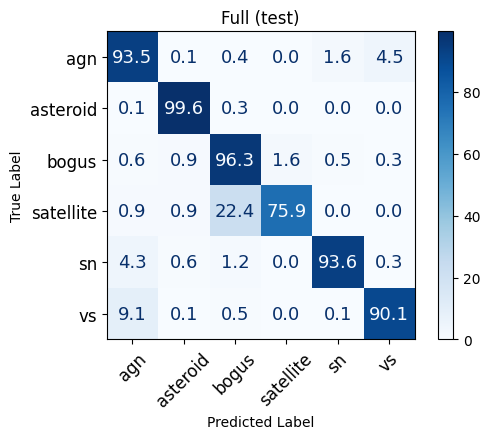

In [25]:
## CON METADATOS
mean_conf_matrix = np.mean(all_conf_matrices, axis=0) * 100

# **2. Graficar la matriz de confusión promedio**
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=mean_conf_matrix, display_labels=LabelEncoder.classes_,)
disp.plot(ax=ax, cmap="Blues", values_format=".1f")

# Ajustes de etiquetas y títulos
plt.xticks(rotation=45, fontsize=12)  # Rotar el eje X
plt.yticks(fontsize=12)  # Aumentar el tamaño en el eje Y
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Full (test)")

# Ajuste del tamaño del texto dentro de la matriz
for text in ax.texts:
    text.set_fontsize(13)  # Aumentar tamaño de los valores en la matriz
plt.show()

In [16]:
# **3. Calcular la media y desviación estándar del classification report**
labels = list(all_class_reports[0].keys())[:-3]  # Excluye 'accuracy', 'macro avg' y 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']

# Crear DataFrame para almacenar resultados
report_df = pd.DataFrame(index=labels, columns=[f'{m}_mean' for m in metrics] + [f'{m}_std' for m in metrics])

# Calcular media y desviación estándar para cada métrica
for label in labels:
    for metric in metrics:
        values = [rep[label][metric] for rep in all_class_reports]
        report_df.at[label, f'{metric}_mean'] = np.mean(values)
        report_df.at[label, f'{metric}_std'] = np.std(values)

report_df*100

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
agn,88.560349,93.452685,90.940767,0.0,0.0,0.0
asteroid,98.122318,99.618736,98.864865,0.0,0.0,0.0
bogus,98.018805,96.273087,97.138103,0.0,0.0,0.0
satellite,64.233577,75.862069,69.565217,0.0,0.0,0.0
sn,93.250689,93.637621,93.443754,0.0,0.0,0.0
vs,94.989669,90.058766,92.458522,0.0,0.0,0.0


In [17]:
# Extraer las métricas macro promedio y su desviación estándar
macro_metrics = ['macro avg']  # Puedes agregar 'weighted avg' si lo necesitas

# Crear DataFrame para los macro promedios
macro_report_df = pd.DataFrame(index=macro_metrics, columns=[f'{m}_mean' for m in ['precision', 'recall', 'f1-score']] +
                                                            [f'{m}_std' for m in ['precision', 'recall', 'f1-score']])

# Calcular media y desviación estándar para los macros
for metric in ['precision', 'recall', 'f1-score']:
    values = [rep['macro avg'][metric] for rep in all_class_reports]
    macro_report_df.at['macro avg', f'{metric}_mean'] = np.mean(values) * 100
    macro_report_df.at['macro avg', f'{metric}_std'] = np.std(values) * 100

macro_report_df

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
macro avg,89.529234,91.483827,90.401871,0.0,0.0,0.0


In [18]:
print('******* Test Set *******')
print(f"F1: {macro_report_df[f'f1-score_mean'].values[0]:.2f} ± {macro_report_df[f'f1-score_std'].values[0]:.2f}") 
print(f"Precision: {macro_report_df[f'precision_mean'].values[0]:.2f} ± {macro_report_df[f'precision_std'].values[0]:.2f}") 
print(f"Recall: {macro_report_df[f'recall_mean'].values[0]:.2f} ± {macro_report_df[f'recall_std'].values[0]:.2f}") 
print('************************')

******* Test Set *******
F1: 90.40 ± 0.00
Precision: 89.53 ± 0.00
Recall: 91.48 ± 0.00
************************


In [19]:
f1_test_paper = 86.68
prec_test_paper = 84.34
recall_test_paper = 90.48

macro_report_df[f'f1-score_mean'].values[0] - f1_test_paper

np.float64(3.721871358615928)

0.19372195662717218

In [38]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

dataset_name = 'full'
BATCH_SIZE = 32  # Ajusta según tu configuración

all_conf_matrices = []
all_class_reports = []

for i in range(5):  # Para las 5 corridas
    with tf.device('/cpu:0'):
        training_dataset, validation_dataset, test_dataset, label_encoder = get_tf_datasets(
            dataset_name=dataset_name, batch_size=BATCH_SIZE)
        
        # Cargar el modelo entrenado para la corrida i
        stamp_classifier = tf.keras.models.load_model(f'{dataset_name}_run_{i}/')

        # Obtener predicciones
        y_val, val_predicted_probs, val_predictions, images_val = evaluate_dataset(stamp_classifier, validation_dataset)

        y_val_labels = LabelEncoder.inverse_transform(y_val)
        val_predictions_labels = LabelEncoder.inverse_transform(val_predictions)

        # Calcular la matriz de confusión
        conf_matrix = confusion_matrix(y_val_labels, val_predictions_labels, labels=LabelEncoder.classes_, normalize='true')
        all_conf_matrices.append(conf_matrix)

        # Calcular el classification report
        report = classification_report(y_val_labels, val_predictions_labels, output_dict=True)
        all_class_reports.append(report)

x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:41:31.357988: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:41:41.030626: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:41:52.047254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:42:01.458283: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_1/Assert/AssertGuard/branch_executed/_47


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:42:12.153323: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_2/Assert/AssertGuard/branch_executed/_66
2025-02-07 08:42:21.494043: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_1/Assert/AssertGuard/branch_executed/_47


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:42:32.456927: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:42:41.868318: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:42:52.767949: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:43:02.335785: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


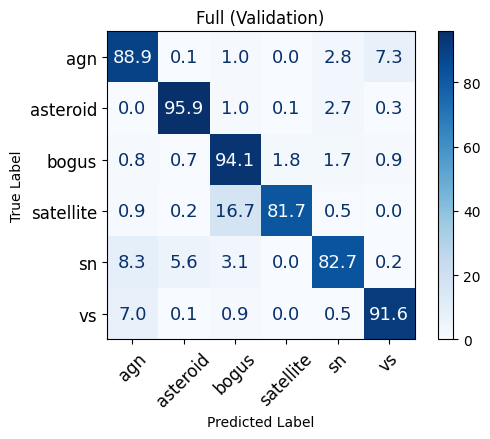

In [45]:
mean_conf_matrix = np.mean(all_conf_matrices, axis=0) * 100

# **2. Graficar la matriz de confusión promedio**
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=mean_conf_matrix, display_labels=LabelEncoder.classes_,)
disp.plot(ax=ax, cmap="Blues", values_format=".1f")

# Ajustes de etiquetas y títulos
plt.xticks(rotation=45, fontsize=12)  # Rotar el eje X
plt.yticks(fontsize=12)  # Aumentar el tamaño en el eje Y
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Full (Validation)")

# Ajuste del tamaño del texto dentro de la matriz
for text in ax.texts:
    text.set_fontsize(13)  # Aumentar tamaño de los valores en la matriz
plt.show()

In [40]:
# **3. Calcular la media y desviación estándar del classification report**
labels = list(all_class_reports[0].keys())[:-3]  # Excluye 'accuracy', 'macro avg' y 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']

# Crear DataFrame para almacenar resultados
report_df = pd.DataFrame(index=labels, columns=[f'{m}_mean' for m in metrics] + [f'{m}_std' for m in metrics])

# Calcular media y desviación estándar para cada métrica
for label in labels:
    for metric in metrics:
        values = [rep[label][metric] for rep in all_class_reports]
        report_df.at[label, f'{metric}_mean'] = np.mean(values)
        report_df.at[label, f'{metric}_std'] = np.std(values)

report_df*100

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
agn,88.270347,88.890026,88.545391,1.268922,2.239778,0.558263
asteroid,96.461751,95.893246,96.167177,0.698752,1.376865,0.540942
bogus,96.868027,94.087774,95.452292,0.765394,0.704765,0.166169
satellite,61.871745,81.724138,70.31949,2.09429,4.021346,0.987691
sn,78.379359,82.710927,80.36352,3.885095,2.547356,1.231768
vs,91.360904,91.576885,91.43387,1.795535,1.807045,0.224377


In [42]:
# Extraer las métricas macro promedio y su desviación estándar
macro_metrics = ['macro avg']  # Puedes agregar 'weighted avg' si lo necesitas

# Crear DataFrame para los macro promedios
macro_report_df = pd.DataFrame(index=macro_metrics, columns=[f'{m}_mean' for m in ['precision', 'recall', 'f1-score']] +
                                                            [f'{m}_std' for m in ['precision', 'recall', 'f1-score']])

# Calcular media y desviación estándar para los macros
for metric in ['precision', 'recall', 'f1-score']:
    values = [rep['macro avg'][metric] for rep in all_class_reports]
    macro_report_df.at['macro avg', f'{metric}_mean'] = np.mean(values) * 100
    macro_report_df.at['macro avg', f'{metric}_std'] = np.std(values) * 100

macro_report_df

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
macro avg,85.535356,89.147166,87.046957,0.512067,0.593025,0.254697


In [43]:
print('******* Validation Set *******')
print(f"F1: {macro_report_df[f'f1-score_mean'].values[0]:.2f} ± {macro_report_df[f'f1-score_std'].values[0]:.2f}") 
print(f"Precision: {macro_report_df[f'precision_mean'].values[0]:.2f} ± {macro_report_df[f'precision_std'].values[0]:.2f}") 
print(f"Recall: {macro_report_df[f'recall_mean'].values[0]:.2f} ± {macro_report_df[f'recall_std'].values[0]:.2f}") 
print('************************')

******* Validation Set *******
F1: 87.05 ± 0.25
Precision: 85.54 ± 0.51
Recall: 89.15 ± 0.59
************************


In [ ]:
mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(figsize, figsize)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_xlabel('Predicted Label', fontsize=fs+2)
ax.set_ylabel('True Label', fontsize=fs+2)

ax.xaxis.label.set_size(fs+2)
ax.yaxis.label.set_size(fs+2)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.savefig(path_save)
plt.close(fig)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Mean Confusion Matrix Over 5 Runs")
plt.show()

In [18]:
dataset_name = 'full'
i = 0

with tf.device('/cpu:0'):
    training_dataset, validation_dataset, test_dataset, label_encoder = get_tf_datasets(
        dataset_name=dataset_name, batch_size=BATCH_SIZE)
    #stamp_classifier = tf.keras.models.load_model(f'saved_models/{dataset_name}_run_{i}/')
    stamp_classifier = tf.keras.models.load_model(f'{dataset_name}_run_{i}/')
    y_val, val_predicted_probs, val_predictions, images_val = evaluate_dataset(stamp_classifier, validation_dataset)

print('y_val:', y_val.shape)
print('val_predictions:', val_predictions.shape)

(9862,)

In [14]:
with tf.device('/cpu:0'):
    y_test, test_predicted_probs, test_predictions, images_test = evaluate_dataset(stamp_classifier, test_dataset)

In [ ]:
print('y_test:', y_test.shape)
print('test_predictions:', test_predictions.shape)

In [45]:
for b in validation_dataset:
    print(b)
    break

(<tf.Tensor: shape=(64, 63, 63, 6), dtype=float32, numpy=
array([[[[ 5.55989780e-02,  2.77429610e-01, -3.79745066e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 9.00271088e-02,  2.71785200e-01,  1.48523405e-01,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 6.00318424e-02,  2.72807121e-01,  2.99650021e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 6.52558804e-02,  2.78823227e-01,  6.73804358e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.78682733e-02,  2.81814069e-01,  2.02923119e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.18669274e-02,  2.79148817e-01,  1.14476290e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 6.76989928e-02,  2.76165426e-01,  6.55059516e-03,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.14817338e-02,  2.77233958e-01, -1.95179328e-01,
    

In [35]:
satellite_cands = images[val_predicted_probs[:, 3] > 0.8]

In [25]:
images = np.concatenate(images, axis=0)
images.shape

(9862, 63, 63, 6)

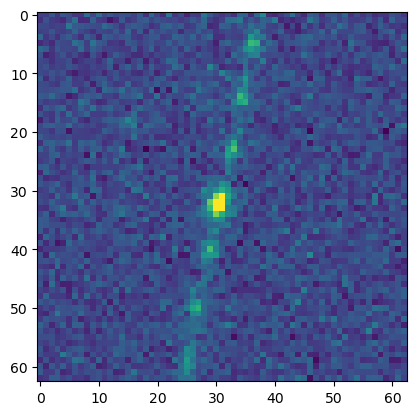

In [44]:
plt.imshow(satellite_cands[8, :, :, 0])